## 0. GPU 사용 가능 여부 확인

In [1]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17646647483852783068
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13916438528
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13552905390601697581
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## 1. 데이터 분할

### 1-0. 데이터 준비 (Colab에서 사용 시)

In [2]:
# colab에서 사용시

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 다운로드
!gdown https://drive.google.com/uc?id=1uBY-JbXcPd-tikzFJcbwSR9_zEjYHHor
!mv /content/dataset.zip /content/drive/MyDrive/04_작물_잎_질병/dataset

# 압축 풀기
%cd /content/drive/MyDrive/04_작물_잎_질병/dataset
!unzip -qq "/content/drive/MyDrive/04_작물_잎_질병/dataset/dataset.zip"

### 1-1. 데이터 분할을 위한 폴더 생성

In [3]:
# laptop에서 작업 시
# working_dir = "D:/python_projects/deep-learning-with-projects/datasets/04_작물_잎_사진_질병_분류/"

# jnu pc에서 작업 시
# working_dir = "C:/Users/user/Downloads/"

# colab에서 작업 시
working_dir = "/content/drive/MyDrive/04_작물_잎_질병/"

In [85]:
import os
import shutil

original_dataset_dir = working_dir + 'dataset'   
classes_list = os.listdir(original_dataset_dir) 
 
base_dir = working_dir + 'splitted' 
# os.mkdir(base_dir)                                # 1회만 실행
 
train_dir = os.path.join(base_dir, 'train') 
# os.mkdir(train_dir)                               # 1회만 실행
validation_dir = os.path.join(base_dir, 'val')
# os.mkdir(validation_dir)                          # 1회만 실행
test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)                                # 1회만 실행

# for cls in classes_list:     
#     os.mkdir(os.path.join(train_dir, cls))        # 1회만 실행
#     os.mkdir(os.path.join(validation_dir, cls))   # 1회만 실행
#     os.mkdir(os.path.join(test_dir, cls))         # 1회만 실행

### 1-2. 데이터 분할과 클래스별 데이터 수 확인

In [5]:
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls) # dataset/~
    fnames = os.listdir(path) # dataset/~/~
 
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    # Train 데이터
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames: 
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst) # src(dataset/~/~)안에 있는 파일 내용을 dst(train 데이터 폴더) 경로로 복사

    # Validation 데이터
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]

    # Test 데이터
    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( Pepper,_bell___healthy ):  886
Validation size( Pepper,_bell___healthy ):  295
Test size( Pepper,_bell___healthy ):  295
Train size( Grape___Esca_(Black_Measles) ):  829
Validation size( Grape___Esca_(Black_Measles) ):  276
Test size( Grape___Esca_(Black_Measles) ):  276
Train size( Pepper,_bell___Bacterial_spot ):  598
Validation size( Pepper,_bell___Bacterial_spot ):  199
Test size( Pepper,_bell___Bacterial_spot ):  199
Train size( Strawberry___healthy ):  273
Validation size( Strawberry___healthy ):  91
Test size( Strawberry___healthy ):  91
Train size( Grape___Black_rot ):  708
Validation size( Grape___Black_rot ):  236
Test size( Grape___Black_rot ):  236
Train size( Corn___Common_rust ):  715
Validation size( Corn___Common_rust ):  238
Test size( Corn___Common_rust ):  238
Train size( Apple___Apple_scab ):  378
Validation size( Apple___Apple_scab ):  126
Test size( Apple___Apple_scab ):  126
Train size( Potato___healthy ):  91
Validation size( Potato___healthy ):  30


## 2. 베이스라인 모델 학습

### 2-1. 베이스라인 모델 학습을 위한 준비

In [80]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

BATCH_SIZE = 256 
EPOCH = 30 

In [81]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
 
transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()]) 
train_dataset = ImageFolder(root=working_dir + 'splitted/train', transform=transform_base) 
val_dataset = ImageFolder(root=working_dir + 'splitted/val', transform=transform_base)

In [82]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 2-2. 데이터 확인

In [83]:
print(len(train_dataset), len(val_dataset))

24677 8332


In [86]:
print("0번 데이터의 0번 원소 : ",train_dataset[0][0].shape)
print("0번 데이터의 1번 원소 : ", train_dataset[0][1])
print("0번 데이터의 Label : ", classes_list[ train_dataset[0][1] ])

0번 데이터의 0번 원소 :  torch.Size([3, 64, 64])
0번 데이터의 1번 원소 :  0
0번 데이터의 Label :  Pepper,_bell___healthy


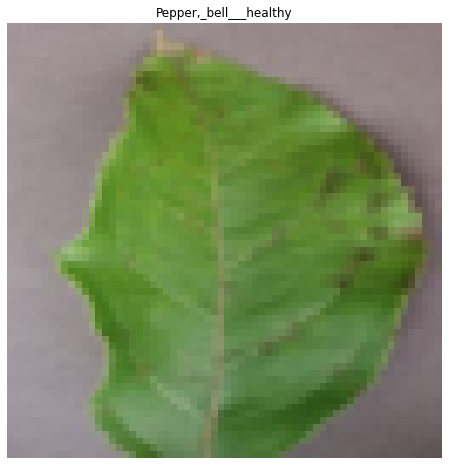

In [87]:
import matplotlib.pyplot as plt

image = train_dataset[0][0].permute(1,2,0)
label = classes_list[ train_dataset[0][1] ]

plt.figure(figsize=(8,8))
plt.axis('off')

plt.imshow(image)
plt.title(label)

plt.show()

In [88]:
first_batch = train_loader.__iter__().__next__()

print("총 batch의 수 :",len(train_loader), end="\n\n")
print("첫 번째 batch의 shape :", first_batch[0].shape, end="\n\n")
print("첫 번째 batch의 label (중간생략) :",first_batch[1][:10])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


총 batch의 수 : 97

첫 번째 batch의 shape : torch.Size([256, 3, 64, 64])

첫 번째 batch의 label (중간생략) : tensor([26, 17,  8, 30, 29, 30, 17, 23,  1, 27])


### 2-3. 베이스라인 모델 설계

In [89]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
class Net(nn.Module): 
  
    def __init__(self): 
    
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.pool = nn.MaxPool2d(2,2)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)  

        self.fc1 = nn.Linear(4096, 512) 
        self.fc2 = nn.Linear(512, 33) 
    
    def forward(self, x):  
    
        x = self.conv1(x)
        x = F.relu(x)  
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training) 

        x = self.conv2(x)
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x) 
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = x.view(-1, 4096)  
        x = self.fc1(x) 
        x = F.relu(x) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x) 

        return F.log_softmax(x, dim=1)  

model_base = Net().to(DEVICE)  
optimizer = optim.Adam(model_base.parameters(), lr=0.001) 

### 2-4. 모델 학습을 위한 함수

In [90]:
def train(model, train_loader, optimizer):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) 
        optimizer.zero_grad() 
        output = model(data)  
        loss = F.cross_entropy(output, target) 
        loss.backward()  
        optimizer.step()  

### 2-5. 모델 평가를 위한 함수

In [91]:
def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE)  
            output = model(data) 
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

### 2-6. 모델 학습

In [92]:
import time
import copy
 
def train_baseline(model ,train_loader, val_loader, optimizer, num_epochs = 30):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        val_loss, val_acc = evaluate(model, val_loader)
        
        if val_acc > best_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    model.load_state_dict(best_model_wts)  
    return model

In [ ]:
base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)  	 #(16)
torch.save(base,'baseline.pt')

-------------- epoch 1 ----------------
train Loss: 1.6946, Accuracy: 53.35%
val Loss: 1.7151, Accuracy: 52.90%
Completed in 5m 59s
-------------- epoch 2 ----------------
train Loss: 1.0632, Accuracy: 68.19%
val Loss: 1.1031, Accuracy: 67.37%
Completed in 5m 18s
-------------- epoch 3 ----------------
train Loss: 0.8229, Accuracy: 74.47%
val Loss: 0.8802, Accuracy: 72.22%
Completed in 4m 40s
-------------- epoch 4 ----------------
train Loss: 0.6074, Accuracy: 81.27%
val Loss: 0.6709, Accuracy: 79.06%
Completed in 4m 35s
-------------- epoch 5 ----------------
train Loss: 0.5588, Accuracy: 82.38%
val Loss: 0.6239, Accuracy: 80.01%
Completed in 4m 34s
-------------- epoch 6 ----------------
train Loss: 0.5168, Accuracy: 83.94%
val Loss: 0.5892, Accuracy: 81.09%
Completed in 4m 35s
-------------- epoch 7 ----------------
train Loss: 0.4386, Accuracy: 86.25%
val Loss: 0.5183, Accuracy: 83.20%
Completed in 4m 33s
-------------- epoch 8 ----------------
train Loss: 0.3643, Accuracy: 88.86%

## 3. Transfer Learning 모델 학습

### 3-1. Transfer Learning을 위한 준비

In [5]:
# colab에서 사용시

from google.colab import drive
drive.mount('/content/drive')

working_dir = "/content/drive/MyDrive/04_작물_잎_질병/"

Mounted at /content/drive


In [93]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# 하이퍼 파라미터 정의
BATCH_SIZE = 256 
EPOCH = 30 

In [94]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 

# transforms 정의(train과 val을 다르게 정의)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([64,64]), # 이미지 사이즈를 64*64로 조정

        # 이미지 Augmentation
        transforms.RandomHorizontalFlip(), # 이미지 좌우반전 (default) p = 0.5
        transforms.RandomVerticalFlip(),  # 이미지 상하반전 (default) p = 0.5
        transforms.RandomCrop(52), # 이미지의 랜덤한 부위를 잘라내어 52*52로 만듦
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) # 정규화를 진행할 ImageNet의 평균과 표편
        ]),
    
    'val': transforms.Compose([
        transforms.Resize([64,64]),  
        transforms.RandomCrop(52), transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]) 
        ])
}

In [95]:
data_dir = working_dir + 'splitted'

# ImageFolder를 사용하여 이미지 불러오기
image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']} 

# 미니 Batch 구성
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']} 

# 데이터셋 사이즈
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 클래스명
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 3-2. Pre-Trained Model 불러오기

In [96]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
 
resnet = models.resnet50(pretrained=True)  # False로 설정시 모델의 구조만 가져오고 파라미터 값은 랜덤으로 설정
print(resnet.fc) # 기존 resnet은 in 2048에 out 1000임

num_ftrs = resnet.fc.in_features   
resnet.fc = nn.Linear(num_ftrs, 33) 
resnet = resnet.to(DEVICE)
 
criterion = nn.CrossEntropyLoss() 
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
 
from torch.optim import lr_scheduler
# 7 epoch마다 학습률에 0.1씩을 곱해줌
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=1000, bias=True)


### 3-3. Pre-Trained Model의 일부 Layer Freeze하기

In [62]:
cnt = 0
for c in resnet.children():
  cnt += 1

print(cnt)

10


In [97]:
ct = 0 
for child in resnet.children():  
    ct += 1  
    if ct < 6: 
        for param in child.parameters():
            param.requires_grad = False

### 3-4. Transfer Learning 모델 학습과 검증을 위한 함수

In [98]:
import time
import copy

def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0  
    
    for epoch in range(num_epochs):
        print('-------------- epoch {} ----------------'.format(epoch+1)) 
        since = time.time()                                     
        for phase in ['train', 'val']: 
            if phase == 'train': 
                model.train() 
            else:
                model.eval()     
 
            running_loss = 0.0  
            running_corrects = 0  
 
            
            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(DEVICE)  
                labels = labels.to(DEVICE)  
                
                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'train'):  
                    outputs = model(inputs)  
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)  
    
                    if phase == 'train':   
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)  
                running_corrects += torch.sum(preds == labels.data)  
            if phase == 'train':  
                scheduler.step()
 
            epoch_loss = running_loss/dataset_sizes[phase]  
            epoch_acc = running_corrects.double()/dataset_sizes[phase]  
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 
 
          
            if phase == 'val' and epoch_acc > best_acc: 
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
        time_elapsed = time.time() - since  
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
 
    model.load_state_dict(best_model_wts) 

    return model

### 3-5. 모델 학습을 실행하기

In [70]:
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH) 

torch.save(model_resnet50, 'resnet50.pt')

-------------- epoch 1 ----------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5778 Acc: 0.8258
val Loss: 0.3665 Acc: 0.8908
Completed in 27m 41s
-------------- epoch 2 ----------------
train Loss: 0.2227 Acc: 0.9279
val Loss: 0.1775 Acc: 0.9440
Completed in 1m 16s
-------------- epoch 3 ----------------
train Loss: 0.1697 Acc: 0.9451
val Loss: 0.2108 Acc: 0.9358
Completed in 1m 16s
-------------- epoch 4 ----------------
train Loss: 0.1292 Acc: 0.9572
val Loss: 0.1647 Acc: 0.9480
Completed in 1m 16s
-------------- epoch 5 ----------------
train Loss: 0.1087 Acc: 0.9639
val Loss: 0.1605 Acc: 0.9486
Completed in 1m 14s
-------------- epoch 6 ----------------
train Loss: 0.0973 Acc: 0.9680
val Loss: 0.0959 Acc: 0.9694
Completed in 1m 16s
-------------- epoch 7 ----------------
train Loss: 0.0854 Acc: 0.9721
val Loss: 0.1005 Acc: 0.9654
Completed in 1m 16s
-------------- epoch 8 ----------------
train Loss: 0.0416 Acc: 0.9855
val Loss: 0.0517 Acc: 0.9844
Completed in 1m 15s
-------------- epoch 9 ----------------
train Loss: 0.0286 Acc: 0.9906
val Loss

## 4. 모델 평가

In [99]:
# colab에서 사용시

from google.colab import drive
drive.mount('/content/drive')

working_dir = "/content/drive/MyDrive/04_작물_잎_질병/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 4-1. 베이스라인 모델 평가를 위한 전처리

In [100]:
# transforms 정의
transform_base = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor()])

# 데이터 불러오기
test_base = ImageFolder(root=working_dir + 'splitted/test',transform=transform_base)  

# 미니배치 구성
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 4-2. Transfer Learning 모델 평가를 위한 전처리

In [101]:
# transforms 정의
transform_resNet = transforms.Compose([
        transforms.Resize([64,64]),  
        transforms.RandomCrop(52),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])

# 데이터 불러오기    
test_resNet = ImageFolder(root=working_dir + 'splitted/test', transform=transform_resNet) 

# 미니배치 구성
test_loader_resNet = torch.utils.data.DataLoader(test_resNet, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 4-3. 베이스 라인 모델 평가

In [104]:
DEVICE = torch.device("cpu")

In [105]:
baseline = torch.load(working_dir + 'model/baseline.pt') 
baseline.eval()  
test_loss, test_accuracy = evaluate(baseline, test_loader_base)

print('baseline test acc:  ', test_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


baseline test acc:   96.52237354085604


### 4-4. Transfer Learning 모델 평가

In [ ]:
DEVICE = torch.device("cuda")

In [103]:
resnet50=torch.load(working_dir + 'model/resnet50.pt') 
resnet50.eval()  
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)

print('ResNet test acc:  ', test_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ResNet test acc:   98.88132295719845
